# PLEASE SEE DETAILS in REPORT.pdf
# Also, the main GRABCUT class I have implemented is in grabcut_helper.py which has been imported in this notebook.
### User refinement examples are present at the bottom

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
#################
import os
import sys
from time import time
import matplotlib.pyplot as plt
import json
import glob
import math
from sklearn import mixture
from collections import Counter
from numpy import linalg as LA
from grabcut_helper import *
import cProfile, pstats, io
import imageio
from time import time

In [3]:
from matplotlib.colors import from_levels_and_colors
use_cmap, use_norm = from_levels_and_colors([0,1,2,3,4,5],['black','green','blue','red','yellow'])

In [4]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                # cv2.circle(image, center_coordinates, radius, color, thickness)
                # Color is BLACK FOR background
                # Color is WHITE for foreground
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [5]:
def run(filename: str, DEFAULT_ITRS=1,connectivity=8, input_num_gmms=5,input_gamma=50 ):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    # storing the ascii values for the colors used in the user annotation
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }
    
    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 3}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 4}
    
    # various flags in the GUI
    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    # read the image
    img = cv2.imread(filename)
    #img=img[300:320, 300:320]
    
    # store a copy
    img2 = img.copy()     
    
    # binary matrix denoting foreground and background
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    #print("Shape of the image is ", img.shape)
    
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented image')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    grabcut_obj=None
    rect_done=False
    
    #print("Initial contents of EventHandler mask is ", Counter((EventObj._mask).flatten()))

    
    while(1):
        
        # stores the image, the mask so far due to GrabCut and the flags of the user operations
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 

            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            #print("Flags are ", FLAGS)

            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            # initially, mask is simply 0 for all
            #print("mask obtained")
            
            # take care that lb_h IS NOT ALWAYS lower than ub_h
            # hence, take care of this technicality+++
            #mask=np.random.randint(2,size=img.shape[:2])
            EventObj.flags = FLAGS
            if FLAGS['rect_over']==True and (not rect_done):
                print("A rectangle has been drawn")
                #mask=fetch_grabcut_mask(img,FLAGS['RECT'] )
                
                ####################################
                '''with open("saved_rects.json",'r') as fd:
                    df=json.load(fd)
                    if filename not in df:
                        df[filename]=[]
                        print("have to write")
                        df[filename]=FLAGS['RECT']
                    FLAGS['RECT']=df[filename]
                with open("saved_rects.json",'w') as fd:
                    json.dump(df, fd)'''
                ###########################
                rect_done=True
                #return None
                grabcut_obj=grabcut_class(img2, FLAGS['RECT'], fetch_gt_path(filename), img, 
                                                  ITERATIONS=DEFAULT_ITRS,
                                                 connectivity=connectivity, 
                                                  NUM_GMMS_PER_LABEL=input_num_gmms,
                                                     gamma_val=input_gamma)

                perform_pipeline(grabcut_obj, DEFAULT_ITRS)
                
            elif rect_done:
                #print("other types of tinkering")
                #plt.imshow(EventObj.mask,cmap=use_cmap, norm=use_norm,interpolation=None)
                #print("Current contents of EventHandler mask is ", Counter((EventObj._mask).flatten()))
                #plt.show()
                grabcut_obj.refine_segmentation(EventObj.mask)
                perform_pipeline(grabcut_obj, 1, False)
                pass
            if grabcut_obj!=None:
                mask=np.copy(grabcut_obj.curr_matte)
                
            # if true, then put 255 else put 0, mask =1 foreground
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
            #save_img_func(fetch_img_cat(filename), output)
            #return grabcut_obj

    return grabcut_obj

In [6]:
def fetch_img_cat(main_path):
    a=main_path.split("/")[-1]
    a=a.split(".")[0]
    return a

In [7]:
def perform_pipeline(ans, NUM_ITRS, make_graph=True):
    if make_graph:
        #start_time = time()
        ans.init_graph()
        #end_time = time()
        #seconds_elapsed = end_time - start_time
        #print("Seconds taken to construct graph is :",seconds_elapsed)
        print("Graph constructed")
    #########################
    for i in range(NUM_ITRS):
        ans.run_an_iteration()
        #print("Distribution is :",Counter(ans.curr_matte.flatten()))
        img_new=fetch_suspected_img(ans.curr_img , ans.curr_matte)
        #plt.imshow(np.flip(img_new, axis=-1))
        #plt.show()
        #print("---------")
    if make_graph:
        print("Initial pipeline over")

### For all plots, first the result of the iterations without any user intervention is shown.
### Then, if there is any user refinement, then the user refinement heatmap is shown and the result of the iteration immediately succeeding the refinement is shown adjacent to the refinement heatmap

# Effect of number of gmms

## Image chosen: Ceramic

#### Case 1: INPUT GMMS allowed=2 , gamma value = 50

In [10]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=4,connectivity=8,input_num_gmms=2, input_gamma=50)
cv2.destroyAllWindows()

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 104, 'w_max': 546, 'h_min': 28, 'h_max': 426}
Graph constructed
Starting iteration: 0
Energy val:  3482747.2635722393
Accuracy is  0.97203125 | Jaccard is  0.91579937672723
--------------------------
Starting iteration: 1
Energy val:  3366222.1589624346
Accuracy is  0.9735123697916667 | Jaccard is  0.9199122055885277
--------------------------
Starting iteration: 2
Energy val:  3366247.573923782
Accuracy is  0.9736263020833333 | Jaccard is  0.9202292105625899
--------------------------
Starting iteration: 3
Energy val:  3366277.2115905094
Accuracy is  0.9736263020833333 | Jaccard is  0.9202292105625899
--------------------------
Initial pipeline over


Total pipeline took 43.371878147125244 secs for 4 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


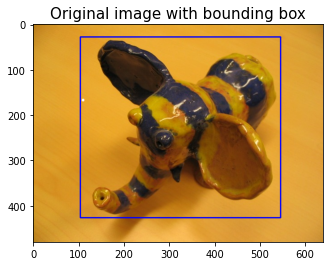

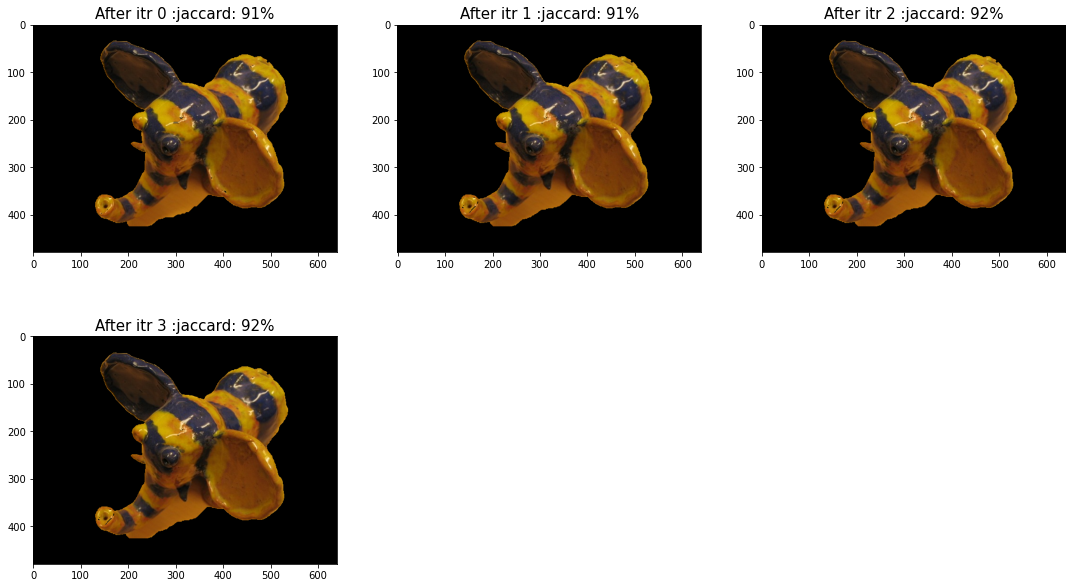

Accuracy:  [0.972, 0.9735, 0.9736, 0.9736]
Jaccard:  [0.9158, 0.9199, 0.9202, 0.9202]
Dice score is:  [0.956, 0.9583, 0.9585, 0.9585]


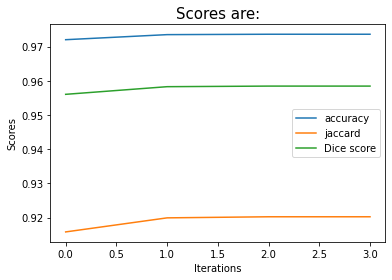

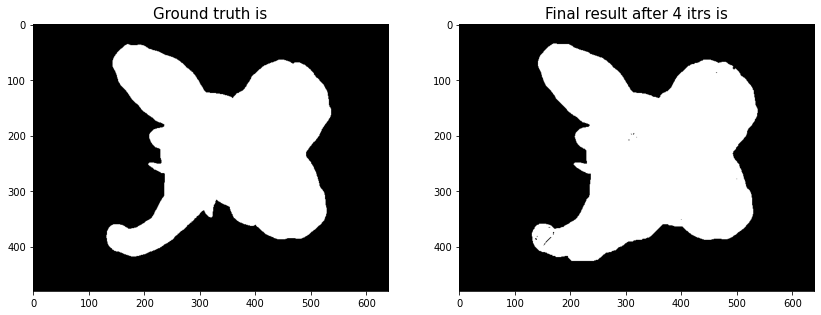

In [11]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

#### Case 2: INPUT GMMS allowed=10 , gamma value = 50

In [23]:
cv2.destroyAllWindows()

In [20]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=2,connectivity=8,input_num_gmms=8, input_gamma=50)
cv2.destroyAllWindows()

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 106, 'w_max': 543, 'h_min': 25, 'h_max': 426}
Graph constructed
Starting iteration: 0
Energy val:  3299074.6457173377
Accuracy is  0.912978515625 | Jaccard is  0.777715877437326
--------------------------
Starting iteration: 1
Energy val:  3212526.160043946
Accuracy is  0.96421875 | Jaccard is  0.8948013168976342
--------------------------
Initial pipeline over


Total pipeline took 64.15707683563232 secs for 2 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


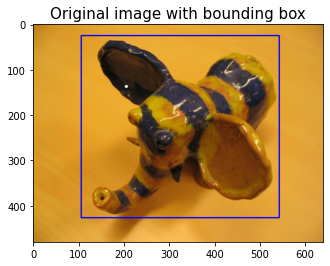

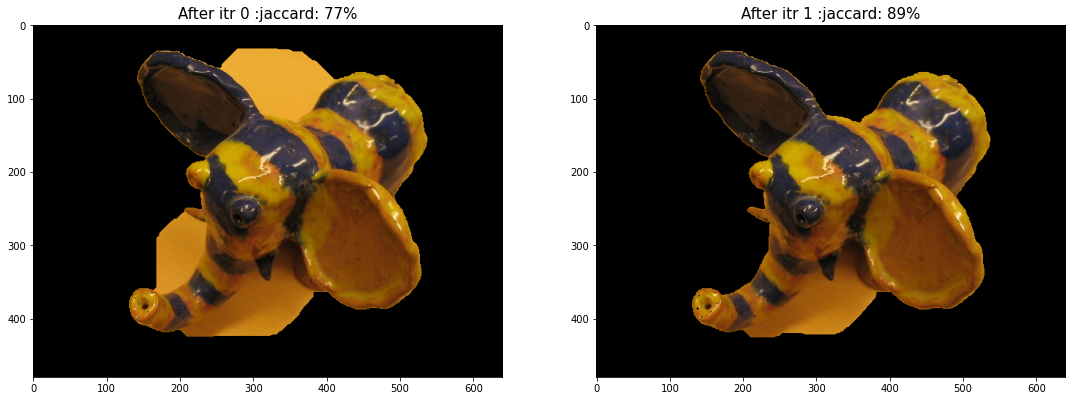

Accuracy:  [0.913, 0.9642]
Jaccard:  [0.7777, 0.8948]
Dice score is:  [0.875, 0.9445]


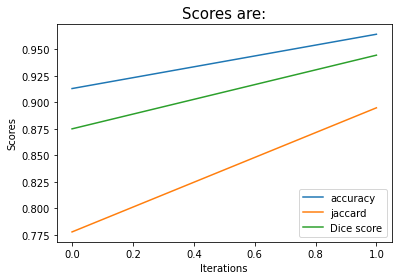

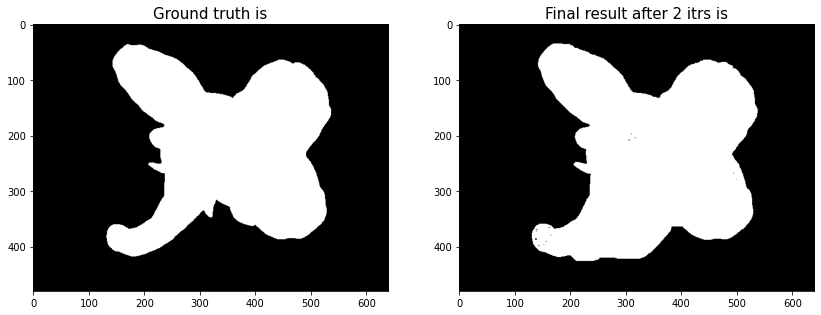

In [21]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)

#### Case 3: INPUT GMMS allowed=10 , gamma value = 200

In [24]:
filename = '../images/ceramic.jpg'               # Path to image file
ans=run(filename,DEFAULT_ITRS=2,connectivity=8,input_num_gmms=10, input_gamma=200)
cv2.destroyAllWindows()

A rectangle has been drawn
Size of the image is [h:480 ,w:640]
Bounding box coordinates:  {'w_min': 117, 'w_max': 541, 'h_min': 26, 'h_max': 423}
Graph constructed
Starting iteration: 0
Energy val:  3363810.9963950645
Accuracy is  0.99224609375 | Jaccard is  0.9751323248457515
--------------------------
Starting iteration: 1
Energy val:  3240410.8789815707
Accuracy is  0.9918294270833333 | Jaccard is  0.9737604148154343
--------------------------
Initial pipeline over


Total pipeline took 79.56201767921448 secs for 2 itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)


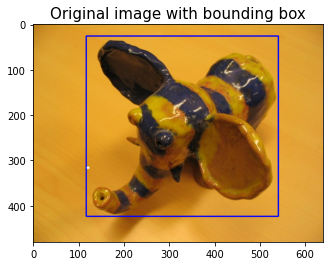

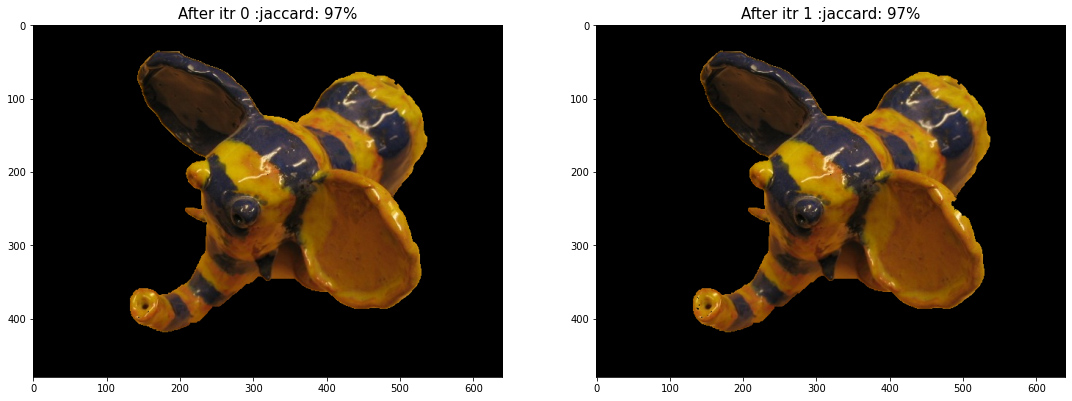

Accuracy:  [0.9922, 0.9918]
Jaccard:  [0.9751, 0.9738]
Dice score is:  [0.9874, 0.9867]


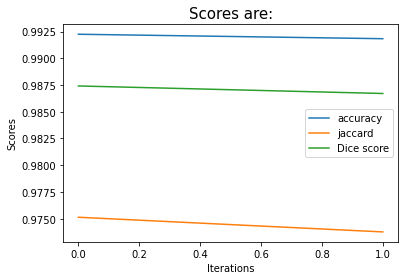

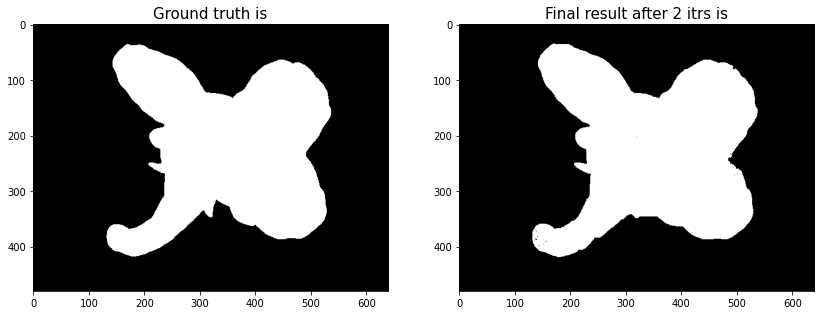

In [25]:
print(f"Total pipeline took {ans.time_track} secs for {len(ans.score_acc)} itrs (including costly overhead for storing state history for each iteration to make plots, user intervention etc)")
plot_all_details(ans)